# Table of contents
1. [Introduction](#introduction)
1. [Import data](#paragraph1)
    1. [Data Dict](#subparagraph1)
    1. [Data Summary](#subparagraph2)
1. [Categorical Features](#paragraph2)
1. [Continuous Features](#paragraph3)
1. [Examining the Target](#paragraph4)
1. [Spatial Analysis](#paragraph5)
1. [Temporal Analysis](#paragraph6)
1. [Preliminary Model_Fitting](#paragraph7)



In [1]:
#pydata
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# display and visualization
pd.options.display.float_format = '{:.2f}'.format
from IPython.core.display import display, HTML, Markdown
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('json')

# custom tools
import sys
sys.path.insert(1, '../scripts/')
# import eda_tools as et
import data_munging_tools as dmt
import model_fitting_tools as mft
import munge_williston_data as mwd
import munge_pipes

# other
import json

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Introduction <a name="introduction"></a>
### Exploring Data

I usually approach EDA in the following way:
1. Create a data dict which we can annotate as we go.
1. For each feature, compute summary statistics for following categories:
    1. Data Type
    1. Missingness
    1. Cardinality (number of unique values)
    1. Central Tendency
    1. Dispersion
    1. Correlation with target
1. Categorical Variables:
    1. Value Counts and Box Plots with the Target
1. Continuous Variables:
    1. Univariate plots (I like stripplots)
    1. Bivariate plots (I like scattermatrices with groups of variables)
    1. Correlation among continuous features (correlation matrix clustermap)
1. Geographic Analysis (if applicable)
    1. Maps, colored by categorical and continuous features
1. Temporal Analysis (if applicable)
    1. Line plots where `time` is on the x-axis



### Load data

In [3]:
data_dict = munge_pipes.make_data_dict()

In [4]:
data_dict

category  \
field_name                                 
api                             metadata   
bakken_isopach_ft                Geology   
bh_lat                          Location   
bh_lng                          Location   
choke_size              CompletionDesign   
countyname                      Location   
currentoperator                 metadata   
currentwellname                 metadata   
data_group                      metadata   
dfelev                          Location   
fieldname                       Location   
fileno                          metadata   
fluid_per_ft            CompletionDesign   
footages                        Location   
grelev                          Location   
kbelev                          Location   
leasename                       Location   
leasenumber                     Location   
legs                    CompletionDesign   
length                  CompletionDesign   
max_tvd                         Location   
mean_tvd                        Location   
min_dist                CompletionDesign   
min_tvd                         Location   
num_pools_produced      CompletionDesign   
originaloperator                metadata   
originalwellname                metadata   
producedpools                    Geology   
production_liquid_120             Target   
production_liquid_150             Target   
production_liquid_180             Target   
production_liquid_1825            Target   
production_liquid_270             Target   
production_liquid_30              Target   
production_liquid_365             Target   
production_liquid_60              Target   
production_liquid_730             Target   
production_liquid_90              Target   
prop_per_ft             CompletionDesign   
qq                              Location   
range                           Location   
section                         Location   
spud_date                       metadata   
spud_year                       metadata   
stage_spacing           CompletionDesign   
std_tvd                         Location   
stimulated_formation             Geology   
surface_lat                     Location   
surface_lng                     Location   
td                              Location   
total_lbs_proppant      CompletionDesign   
total_num_stages        CompletionDesign   
total_volume_bbls       CompletionDesign   
township                        Location   
tvd                             Location   
type_treatment          CompletionDesign   
well_status_date                metadata   
wellbore                        metadata   
wellstatus                      metadata   
welltype                        metadata   

                                                              description  \
field_name                                                                  
api                               Globally unique identifier for the well   
bakken_isopach_ft       Thickness of the oil producing Bakken formatio...   
bh_lat                  Latitude of the 'bottom hole' (the end of the ...   
bh_lng                  Longitude of the 'bottom hole' (the end of the...   
choke_size              Diameter in inches of the mechanical flow limiter   
countyname                   Name of the County where the well is located   
currentoperator                Name of the Company that operates the well   
currentwellname         Name of the well; essentially free text, namin...   
data_group                                                  train or test   
dfelev                                           Drilling floor elevation   
fieldname                    Name of the Field where this well is located   
fileno                      North Dakota specific identifier for the well   
fluid_per_ft                                                         None   
footages                Description of where the well pad is located i...   
grelev                                                   Graded elevati

In [5]:
data_dict.query("using == True").index.tolist()

['bakken_isopach_ft',
 'choke_size',
 'fluid_per_ft',
 'length',
 'min_dist',
 'production_liquid_180',
 'prop_per_ft',
 'spud_year',
 'stage_spacing',
 'std_tvd',
 'stimulated_formation',
 'surface_lat',
 'surface_lng',
 'total_lbs_proppant',
 'total_num_stages',
 'total_volume_bbls',
 'tvd']

In [6]:
display(Markdown("### Data Dict"))
data_dict.head().style.set_properties(subset=['description'], **{'width': '700px'})

### Data Dict

In [7]:
# Specify some columns for future reference
coord_cols = ["surface_lat", "surface_lng", "bh_lat", "bh_lng"]
target_col = "production_liquid_180"

## Create a dataframe for further inspection
There's actually quite a bit going on here behind the scenes (i.e., inside `munge_pipes.py`).  
I'm doing some basic data munging and feature engineering before even looking at the data.
Two main things are happening:
1. I want a per-foot calculation for many of the completion features, because that gives a true notion of "stimulation intensity"
    1. In order to do so, we need some notion of the lateral length of each well. 
    1. Looking at it in per-foot terms also helps us spot outliers and uncover patterns
1. Another thing we can calculate relatively easily is interwell spacing.
    1. I do this by first calculating a midpoint for each well and then calculating pairwise distances between each midpoint and picking the shortest for each well.


In [8]:
inspect_df = munge_pipes.make_inspect_df(coord_cols=coord_cols)

In [9]:
# I almost always look at the head and tail of the data first.
display(inspect_df.head(1),
        inspect_df.tail(1)
       )

bakken_isopach_ft  bh_lat  bh_lng  choke_size countyname  \
api                                                                        
33023010680000              90.00   48.73 -103.85        0.44     DIVIDE   

                 currentoperator                 currentwellname data_group  \
api                                                                           
33023010680000  HUNT OIL COMPANY  WRITING ROCK  161-101-30-31H-1       TEST   

                dfelev     fieldname  ...  wellstatus welltype  mid_lat  \
api                                   ...                                 
33023010680000     nan  WRITING ROCK  ...           A       OG    48.74   

                mid_lng min_dist  length  prop_per_ft  fluid_per_ft  \
api                                                                   
33023010680000  -103.85  9667.07 6164.12       438.36          9.44   

                stage_spacing  spud_year  
api                                       
33023010680000           0.00    2013.00  

[1 rows x 61 columns]

bakken_isopach_ft  bh_lat  bh_lng  choke_size countyname  \
api                                                                        
33007016960000              40.00   47.30 -103.08        0.41   BILLINGS   

                   currentoperator             currentwellname data_group  \
api                                                                         
33007016960000  PETRO-HUNT, L.L.C.  ZABOLOTNY  144-98-3A-10-1H      TRAIN   

                dfelev     fieldname  ...  wellstatus welltype  mid_lat  \
api                                   ...                                 
33007016960000     nan  LITTLE KNIFE  ...           A       OG    47.31   

                mid_lng min_dist   length  prop_per_ft  fluid_per_ft  \
api                                                                    
33007016960000  -103.08 10958.05 10357.79       268.25          5.98   

                stage_spacing  spud_year  
api                                       
33007016960000           0.00    2012.00  

[1 rows x 61 columns]

In [10]:
df_summary = dmt.make_df_summary(inspect_df, target_col=target_col)
# display(df_summary.head())

In [11]:
df_summary[df_summary.dtype != "object"]

dtype num_unique perc_missing       mean        std  \
column                                                                          
fileno                    int64       8115         0.00   22476.12    3247.85   
num_pools_produced        int64          2         0.00       1.00       0.02   
section                   int64         36         0.00      18.06      10.47   
total_num_stages          int64         74         0.00      25.78      10.97   
bakken_isopach_ft       float64         14         0.00      86.66      24.66   
bh_lat                  float64       7517         5.08      48.00       0.45   
bh_lng                  float64       7668         5.08    -102.94       0.52   
choke_size              float64         62        20.67       0.47       0.19   
dfelev                  float64          2        99.98    2452.50      57.28   
fluid_per_ft            float64       6509        19.79      19.76     209.30   
grelev                  float64        895        17.42    2261.92     722.89   
kbelev                  float64        913         5.96    2263.23     183.87   
legs                    float64          8         5.08       2.21       0.54   
length                  float64       7703         5.08    8498.67    2843.76   
max_tvd                 float64       7562         5.08   10259.22    1119.54   
mean_tvd                float64       7703         5.08   10173.52    1129.57   
mid_lat                 float64       7703         5.08      48.01       0.45   
mid_lng                 float64       7703         5.08    -102.94       0.52   
min_dist                float64       5276         5.08    2457.09    3414.10   
min_tvd                 float64       7576         5.08    9623.74    1186.00   
production_liquid_120   float64       7575         2.12   45680.49   25289.98   
production_liquid_150   float64       7559         2.56   53477.39   29466.85   
production_liquid_180   float64       7554         3.43   60534.37   33356.20   
production_liquid_1825  float64        820        89.90  204252.99  154348.70   
production_liquid_270   float64       7167         9.06   77632.81   43415.06   
production_liquid_30    float64       7035         1.64   15242.69    9411.31   
production_liquid_365   float64       6628        16.45   91839.72   51884.02   
production_liquid_60    float64       7425         1.82   27056.62   15598.20   
production_liquid_730   float64       4585        43.02  129887.16   73864.35   
production_liquid_90    float64       7516         1.98   36972.55   20721.72   
prop_per_ft             float64       6630        18.30     962.71   11075.74   
spud_year               float64         12         0.44    2011.67       1.80   
stage_spacing           float64       7703         5.08       0.01       0.11   
std_tvd                 float64       7703         5.08     130.57      89.65   
surface_lat             float64       7957         0.00      48.01       0.45   
surface_lng             float64       7935         0.00    -102.93       0.52   
td                      float64       3829         0.18   19446.52    2515.49   
total_lbs_proppant      float64       6858        13.33 3139137.49 4012517.07   
total_volume_bbls       float64       6606        14.82   65553.28   63878.26   
tvd                     float64       7584         5.08   10232.45    1123.33   

                       coeff_var  entropy      min        25%        50%  \
column                                                                     
fileno                      0.14      nan 11259.00   19801.50   22548.00   
num_pools_produced          0.02      nan     1.00       1.00       1.00   
section                     0.58      nan     1.00       9.00      18.00   
total_num_stages            0.43      nan     1.00      21.00      30.00   
bakken_isopach_ft           0.28      nan    10.00      70.00      90.00   
bh_lat                      0.01      nan    46.56      47.75      48.01   
bh_lng         

In [12]:
summary_df = df_summary.join(data_dict)

In [13]:
print("Feature categories already in the data dict:")
summary_df.category.value_counts(dropna=False)

Feature categories already in the data dict:


Location            22
CompletionDesign    12
metadata            12
Target              10
Geology              3
NaN                  2
Name: category, dtype: int64

 <a name="paragraph2"></a>
# Inspect Categorical Features

In [14]:
cat_df = inspect_df.copy().select_dtypes("O")

In [15]:
for col in cat_df.columns:
    nunique = cat_df[col].nunique()
    display(Markdown(f"### {col}: {nunique}"))
    display(cat_df[col].value_counts().to_frame().reset_index().head(5))

### countyname: 15

index  countyname
0   MCKENZIE        2229
1  MOUNTRAIL        1997
2       DUNN        1343
3   WILLIAMS        1336
4     DIVIDE         540

### currentoperator: 57

index  currentoperator
0  WHITING OIL AND GAS CORPORATION             1079
1      CONTINENTAL RESOURCES, INC.              926
2  HESS BAKKEN INVESTMENTS II, LLC              814
3              EOG RESOURCES, INC.              515
4                  XTO ENERGY INC.              514

### currentwellname: 8114

index  currentwellname
0                   PENNINGTON  41-4H                2
1                   MONTPELIER  2-14H                1
2  J. GARVIN JACOBSON  150-101-8-5-1H                1
3      AUDREY RABBITHEAD HALL  33-11H                1
4                MONTCLAIR  0112-6TFH                1

### data_group: 2

index  data_group
0  TRAIN        6529
1   TEST        1586

### fieldname: 342

index  fieldname
0        SANISH        485
1      PARSHALL        328
2         ALGER        251
3  MURPHY CREEK        168
4     SIVERSTON        158

### footages: 7537

index  footages
0  250 FNL  1320 FWL        14
1  300 FSL  1320 FEL        13
2  300 FNL  1320 FEL        13
3   500 FNL  500 FWL        10
4   300 FNL  300 FWL         9

### leasename: 3712

index  leasename
0  FORT BERTHOLD        113
1            MHA         86
2       WAYZETTA         58
3         AUSTIN         47
4       PARSHALL         43

### leasenumber: 5421

index  leasenumber
0    1-H           84
1      1           31
2  1-22H           24
3  1-29H           23
4    #1H           21

### originaloperator: 102

index  originaloperator
0      CONTINENTAL RESOURCES, INC.               889
1  WHITING OIL AND GAS CORPORATION               746
2                 HESS CORPORATION               676
3              EOG RESOURCES, INC.               516
4             MARATHON OIL COMPANY               441

### originalwellname: 8108

index  originalwellname
0  STATE OF NORTH DAKOTA  154-99-16A-5H                 2
1                         BAKER  29-31H                 2
2                         HANSEN  21-3H                 2
3                           ANGUS  2-9H                 2
4                     PENNINGTON  41-4H                 2

### producedpools: 15

index  producedpools
0              BAKKEN           7845
1              SANISH            102
2           SPEARFISH             88
3  BAKKEN/THREE FORKS             37
4             MADISON             10

### qq: 47

index    qq
0  SWSE  1136
1  SESE   927
2  SESW   926
3  NENW   791
4  NWNW   747

### range: 25

index  range
0  95 W    935
1  92 W    811
2  96 W    733
3  99 W    710
4  93 W    703

### spud_date: 2258

index  spud_date
0  2013-05-02         14
1  2013-01-15         14
2  2012-10-01         14
3  2013-06-18         13
4  2013-11-27         12

### stimulated_formation: 15

index  stimulated_formation
0       bakken                  4951
1  three forks                  2016
2    spearfish                   104
3    pronghorn                    10
4      madison                     5

### township: 30

index  township
0  152 N       824
1  153 N       728
2  154 N       682
3  155 N       652
4  151 N       652

### type_treatment: 9

index  type_treatment
0           sand frac            5729
1               other             797
2            fracture             184
3  fracture,sand frac               3
4     other,sand frac               3

### well_status_date: 2286

index  well_status_date
0  2012-12-14                15
1  2013-04-18                15
2  2014-07-29                14
3  2012-05-11                14
4  2013-09-20                14

### wellbore: 3

index  wellbore
0           HORIZONTAL      8104
1  HORIZONTAL RE-ENTRY         6
2          DIRECTIONAL         5

### wellstatus: 8

index  wellstatus
0     A        7773
1    IA         305
2    TA          10
3    PA           8
4    AB           7

### welltype: 1

index  welltype
0    OG      8115

## Categorical Plots

In [16]:
cat_df = (inspect_df.copy()
                  .select_dtypes("O")
                  .pipe(dmt.reduce_cardinality)
         )

cat_cols = cat_df.columns

cat_df = cat_df.join(inspect_df.filter([target_col]))

In [17]:
print("categorical features:")
cat_cols

categorical features:


Index(['countyname', 'currentoperator', 'currentwellname', 'data_group',
       'fieldname', 'footages', 'leasename', 'leasenumber', 'originaloperator',
       'originalwellname', 'producedpools', 'qq', 'range', 'spud_date',
       'stimulated_formation', 'township', 'type_treatment',
       'well_status_date', 'wellbore', 'wellstatus', 'welltype'],
      dtype='object')

In [18]:
# dmt.inspect_cat_plots(cat_df, "choke_size", target_col)

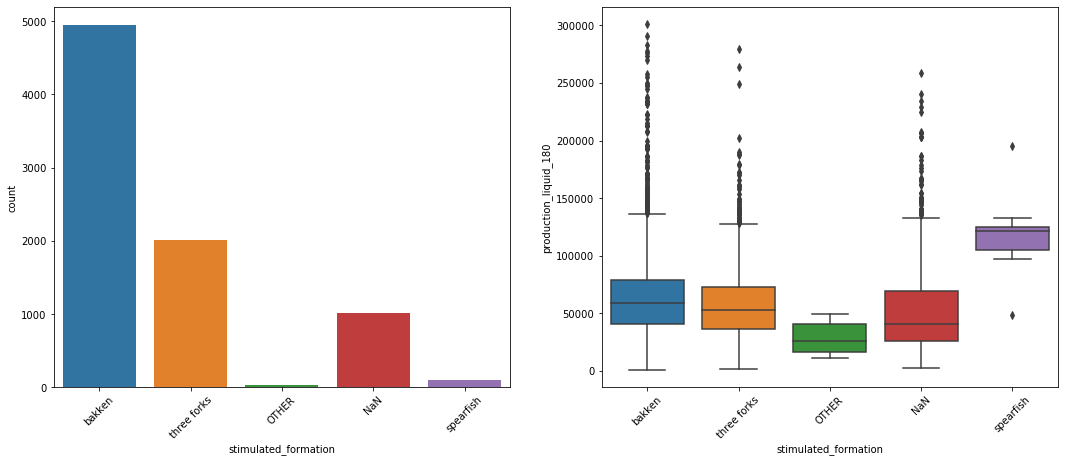

In [19]:
dmt.inspect_cat_plots(cat_df, "stimulated_formation", target_col)

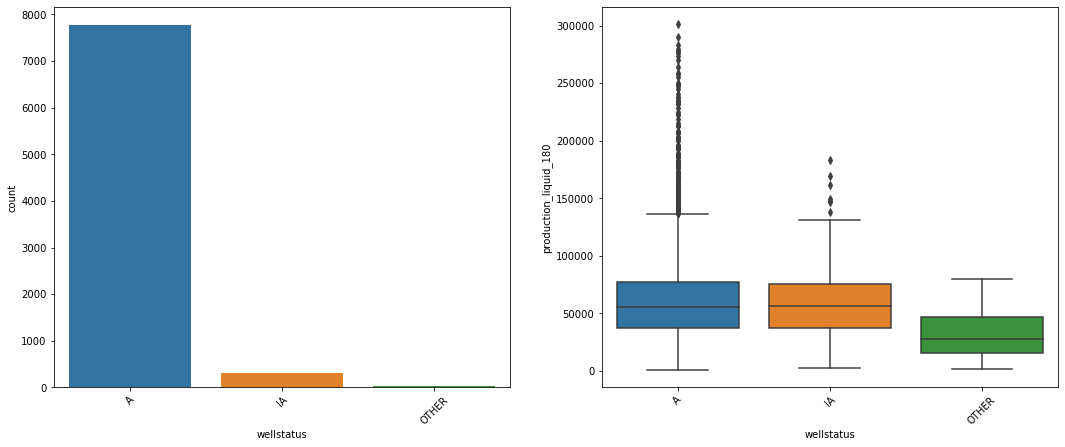

In [20]:
dmt.inspect_cat_plots(cat_df, "wellstatus", target_col)

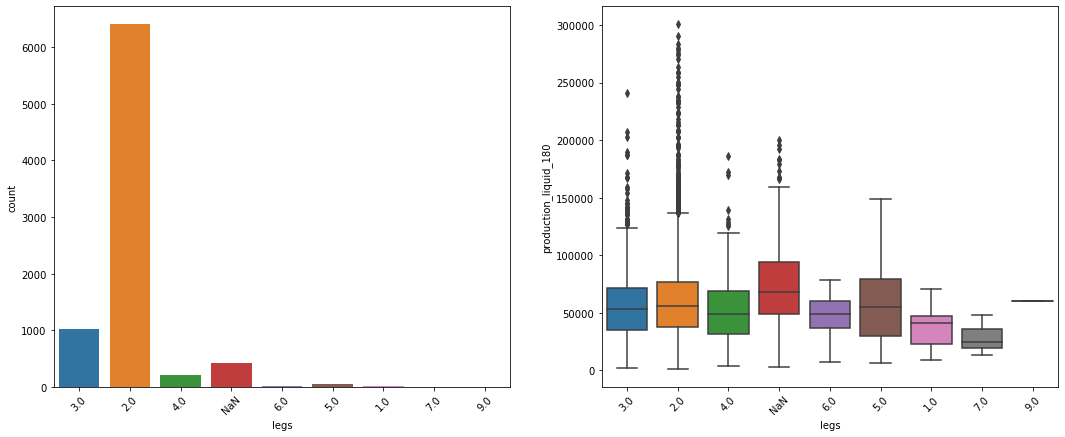

In [21]:
dmt.inspect_cat_plots(inspect_df, "legs", target_col)

### Conclusion: theres nothing really useful here, except maybe choke size, legs, and stimulated formation

# Inspect Continuous Features  <a name="paragraph3"></a>

In [22]:
foi = sorted([
'total_lbs_proppant',
'total_num_stages', 
'total_volume_bbls',
'length',
'legs',
'prop_per_ft',
'fluid_per_ft', 
'stage_spacing', 
'mean_tvd',
'bakken_isopach_ft',
'choke_size',
'min_dist',
target_col
])

total_cols = sorted([
'total_lbs_proppant',
'total_num_stages', 
'total_volume_bbls',
'length',
target_col
])

normd_cols = sorted([
'prop_per_ft',
'fluid_per_ft', 
'stage_spacing',
target_col
])

other = sorted([
'mean_tvd',
'bakken_isopach_ft' 
])

In [23]:
cont_df = (inspect_df.copy()
#                    .assign(choke_size=lambda x: x["choke_size"].apply(lambda x: mwd.parse_choke_size(x)))
                   .select_dtypes("number")
                   .filter(foi)
                   .sort_index(axis=1)
          )

In [24]:
cont_df.shape

(8115, 13)

In [25]:
cont_df.columns

Index(['bakken_isopach_ft', 'choke_size', 'fluid_per_ft', 'legs', 'length',
       'mean_tvd', 'min_dist', 'production_liquid_180', 'prop_per_ft',
       'stage_spacing', 'total_lbs_proppant', 'total_num_stages',
       'total_volume_bbls'],
      dtype='object')

## Setting extreme outliers to NaN

In [26]:
thresh_dict = defaultdict(lambda: {"min": 0, "max": float("inf")})
thresh_dict["total_lbs_proppant"]["max"] = 20000000.0
thresh_dict["total_volume_bbls"]["max"] = 500000.0
thresh_dict["length"]["min"] = 2000
# thresh_dict["mean_tvd"]["min"] = 4000
thresh_dict["total_num_stages"]["min"] = 5

In [27]:
thresh_dict

defaultdict(<function __main__.<lambda>()>,
            {'total_lbs_proppant': {'min': 0, 'max': 20000000.0},
             'total_volume_bbls': {'min': 0, 'max': 500000.0},
             'length': {'min': 2000, 'max': inf},
             'total_num_stages': {'min': 5, 'max': inf}})

In [28]:
cont_df.head()

bakken_isopach_ft  choke_size  fluid_per_ft  legs   length  \
api                                                                          
33023010680000              90.00        0.44          9.44  3.00  6164.12   
33061019000000             110.00        1.00          2.97  2.00  9150.57   
33053051430000              80.00        0.28          1.62  2.00  9926.80   
33053045070000              80.00        0.34          4.69  2.00 10054.43   
33053047660000              90.00        0.61         34.53  3.00  2785.10   

                mean_tvd  min_dist  production_liquid_180  prop_per_ft  \
api                                                                      
33023010680000   8682.48   9667.07               25694.00       438.36   
33061019000000   9827.68   1319.36               45299.00       204.01   
33053051430000  10980.10    411.63               12653.00       166.36   
33053045070000  11024.49   2760.67               79246.00       648.03   
33053047660000  11109.07   3596.86               74794.00      1526.69   

                stage_spacing  total_lbs_proppant  total_num_stages  \
api                                                                   
33023010680000           0.00          2702100.00                25   
33061019000000           0.00          1866840.00                26   
33053051430000           0.00          1651440.00                32   
33053045070000           0.00          6515590.00                23   
33053047660000           0.01          4251992.00                33   

                total_volume_bbls  
api                                
33023010680000           58176.00  
33061019000000           27187.00  
33053051430000           16129.00  
33053045070000           47161.00  
33053047660000           96171.00

In [29]:
cont_df.shape

(8115, 13)

In [30]:
inspect_df.columns

Index(['bakken_isopach_ft', 'bh_lat', 'bh_lng', 'choke_size', 'countyname',
       'currentoperator', 'currentwellname', 'data_group', 'dfelev',
       'fieldname', 'fileno', 'footages', 'grelev', 'kbelev', 'leasename',
       'leasenumber', 'legs', 'max_tvd', 'mean_tvd', 'min_tvd',
       'num_pools_produced', 'originaloperator', 'originalwellname',
       'producedpools', 'production_liquid_120', 'production_liquid_150',
       'production_liquid_180', 'production_liquid_1825',
       'production_liquid_270', 'production_liquid_30',
       'production_liquid_365', 'production_liquid_60',
       'production_liquid_730', 'production_liquid_90', 'qq', 'range',
       'section', 'spud_date', 'std_tvd', 'stimulated_formation',
       'surface_lat', 'surface_lng', 'td', 'total_lbs_proppant',
       'total_num_stages', 'total_volume_bbls', 'township', 'tvd',
       'type_treatment', 'well_status_date', 'wellbore', 'wellstatus',
       'welltype', 'mid_lat', 'mid_lng', 'min_dist', 'length', 

In [31]:
num_missing = inspect_df[foi + coord_cols].isnull().sum(axis=1).sort_values(ascending=False)

In [32]:
num_missing.head()

api
33053060140000    13
33089005680000    13
33007015830000    12
33053059140000    12
33053059160000    12
dtype: int64

{'min': 0, 'max': 500000.0}
1207


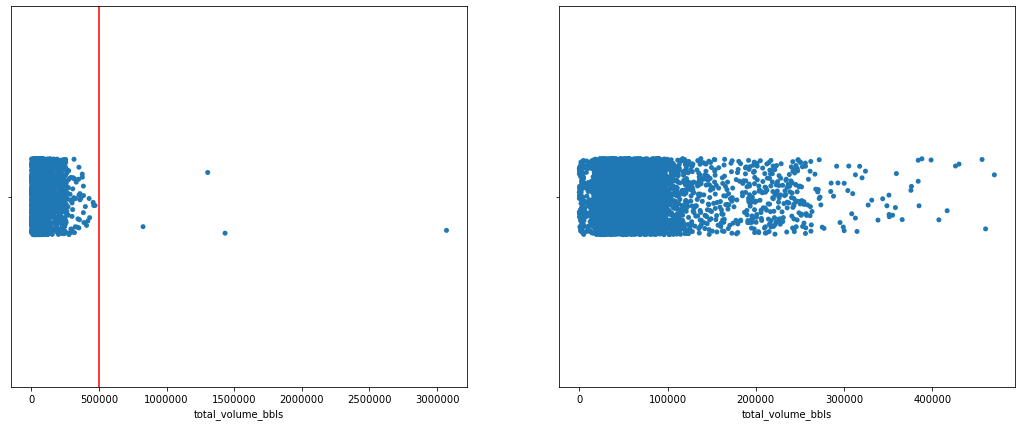

In [33]:
dmt.make_strip_plots(cont_df, "total_volume_bbls", thresh_dict)

{'min': 0, 'max': inf}


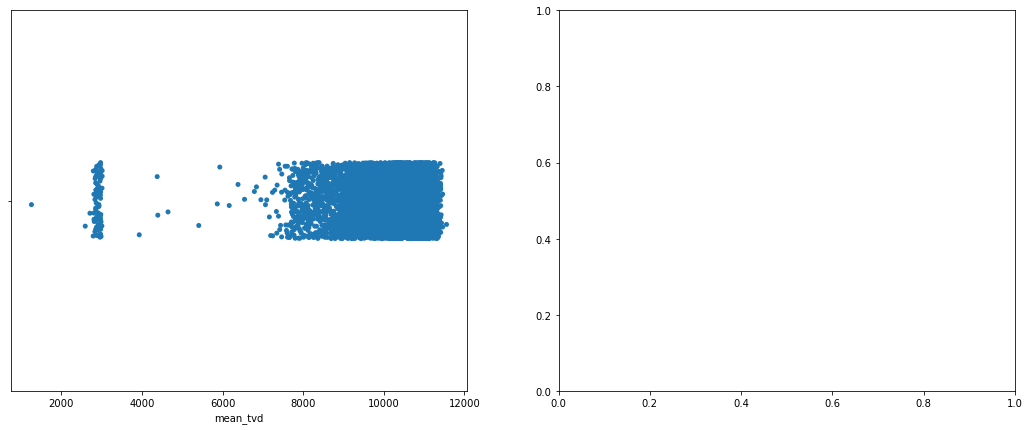

In [34]:
dmt.make_strip_plots(cont_df, "mean_tvd", thresh_dict)

{'min': 5, 'max': inf}
747


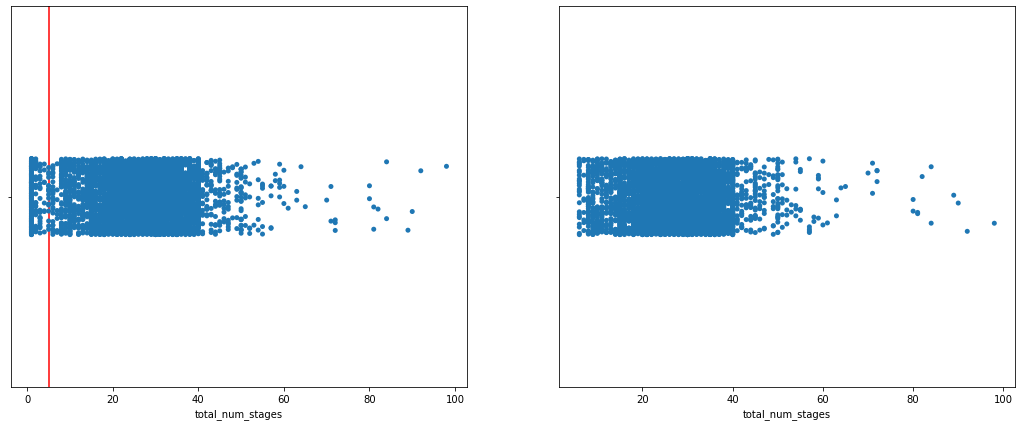

In [35]:
dmt.make_strip_plots(cont_df, "total_num_stages", thresh_dict)

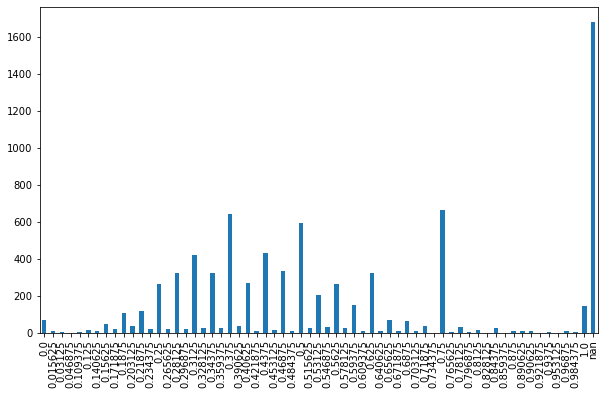

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))
cont_df.choke_size.value_counts(dropna=False).sort_index().plot.bar()

### Examining Target

In [37]:
display(Markdown("### 224 wells in the training set are missing target values at IP 180"))
inspect_df.query(f"{target_col} != {target_col} & data_group == 'TRAIN'").shape

### 224 wells in the training set are missing target values at IP 180

(224, 61)

In [38]:
display(Markdown("### 54 wells in the test set are missing target values at IP 180"))
inspect_df.query(f"{target_col} != {target_col}  & data_group == 'TEST'").shape

### 54 wells in the test set are missing target values at IP 180

(54, 61)

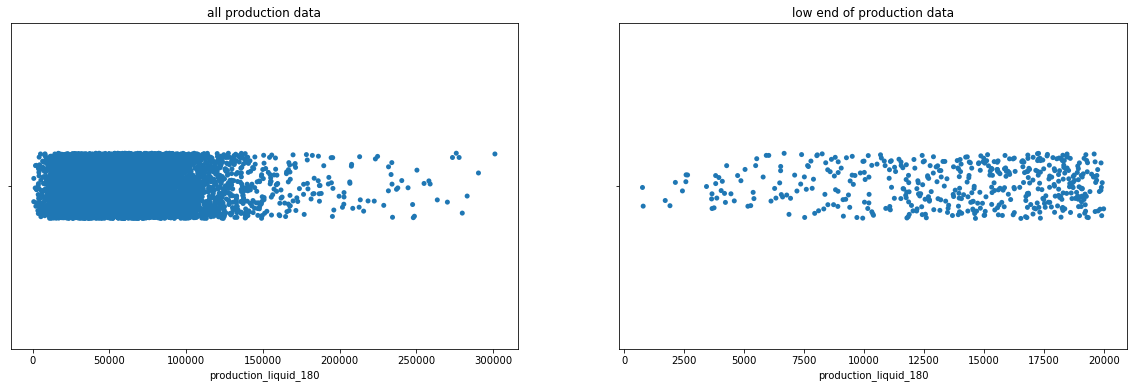

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.stripplot(inspect_df[target_col], ax=ax[0])
sns.stripplot(inspect_df.query(f"{target_col} < 20000")[target_col], ax=ax[1])
ax[0].set_title("all production data")
ax[1].set_title("low end of production data")
plt.show()

In [40]:
clean_df = (inspect_df.copy()
#                     .assign(choke_size= lambda x: x["choke_size"].apply(mwd.parse_choke_size))
                    .pipe(dmt.remove_outiers, thresh_dict)
                    .assign(prop_per_ft=lambda x: x["total_lbs_proppant"] / x["length"],
                            fluid_per_ft=lambda x: x["total_volume_bbls"]/ x["length"],
                            stage_spacing=lambda x: x["total_num_stages"] / x["length"]
                            )
           )

total_lbs_proppant
total_volume_bbls
length
total_num_stages
mean_tvd


### Comparing Total Measurements (After scrubbing outliers)

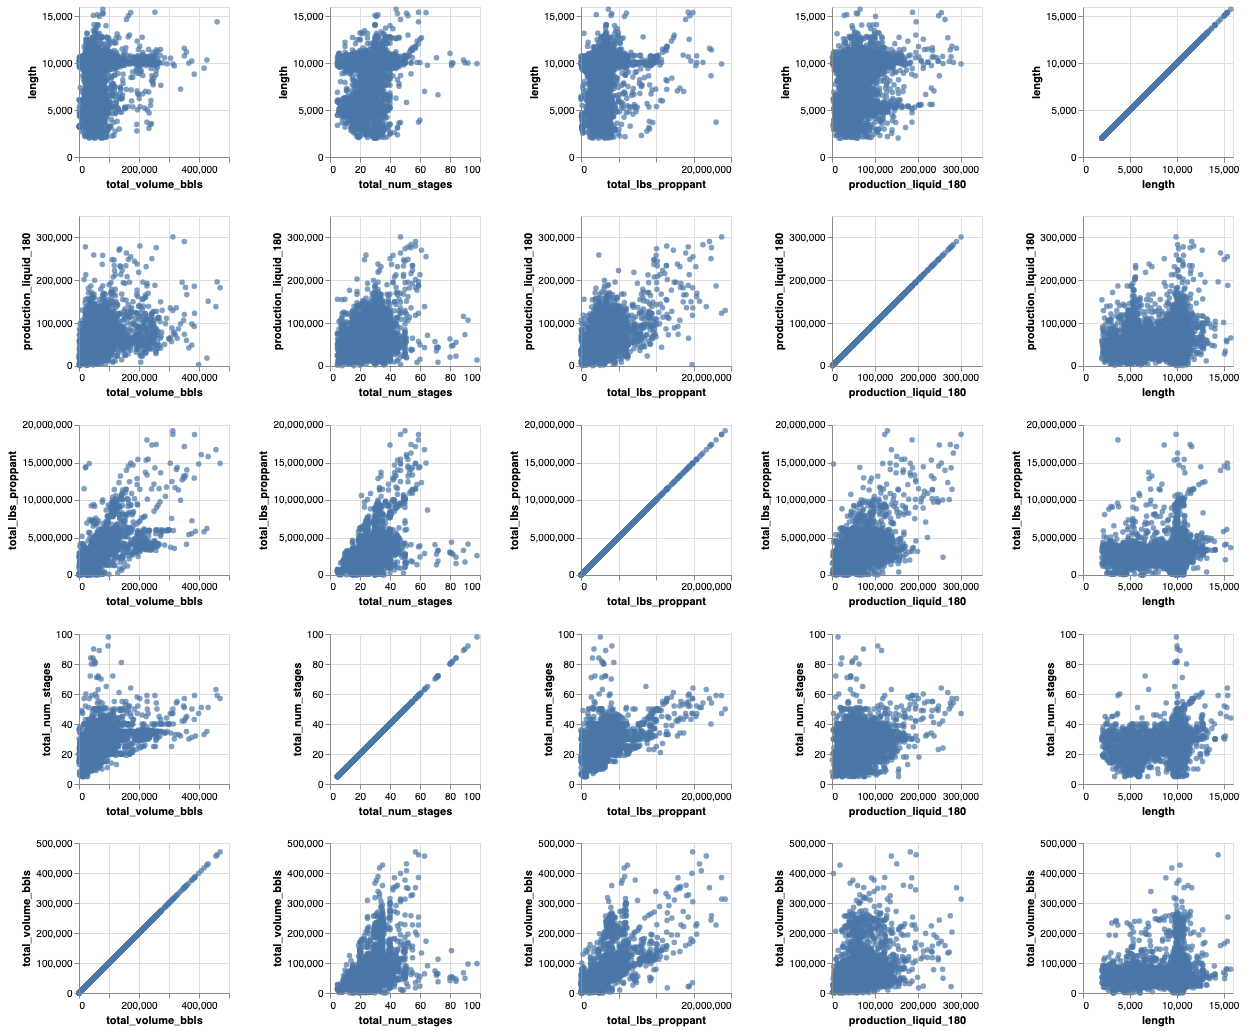

In [41]:
display(Markdown("### Comparing Total Measurements (After scrubbing outliers)"))
alt.Chart(clean_df[total_cols]).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
).properties(
    width=150,
    height=150
).repeat(
    row=total_cols,
    column=total_cols[::-1]
)

### Comparing Normalized Measurements (After scrubbing outliers)

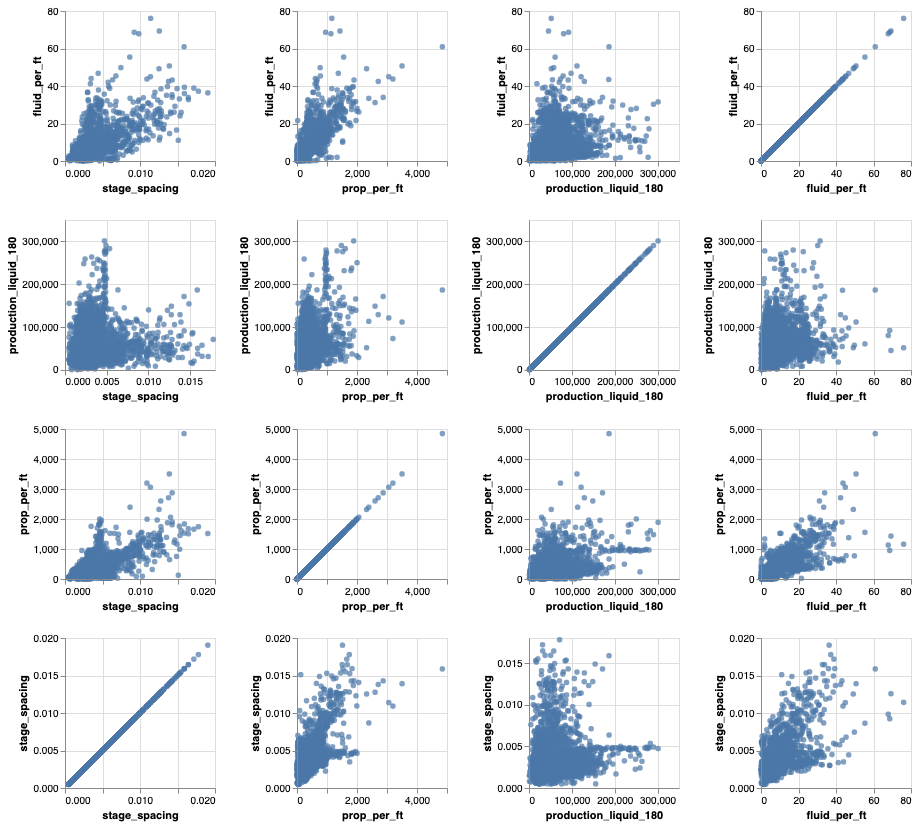

In [42]:
display(Markdown("### Comparing Normalized Measurements (After scrubbing outliers)"))
alt.Chart(clean_df).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
#     color='Origin:N'
).properties(
    width=150,
    height=150
).repeat(
    row=normd_cols,
    column=normd_cols[::-1]
)

In [43]:
tvd_cols = inspect_df.filter(regex="tvd").columns.tolist() + ["td"]

In [44]:
tvd_cols

['max_tvd', 'mean_tvd', 'min_tvd', 'std_tvd', 'tvd', 'td']

### Comparing Depth Measurements

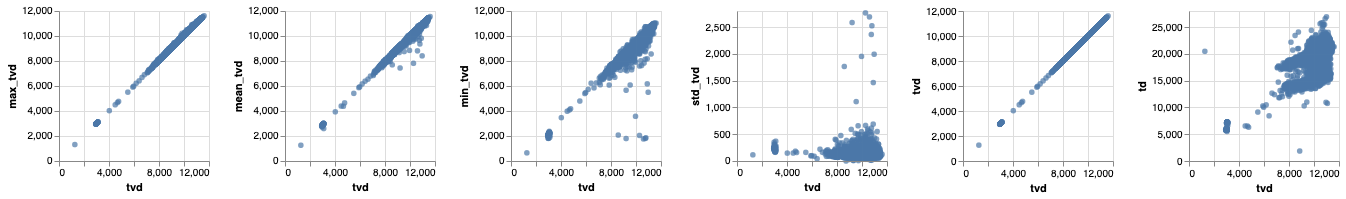

In [45]:
display(Markdown("### Comparing Depth Measurements"))
alt.Chart(inspect_df[tvd_cols]).mark_circle().encode(
    alt.X("tvd", type='quantitative'),
    alt.Y(alt.repeat("column"), type='quantitative'),
).properties(
    width=150,
    height=150
).repeat(
    column=tvd_cols,
)

### Correlation Matrix Heatmap, with Hierarchical Clustering

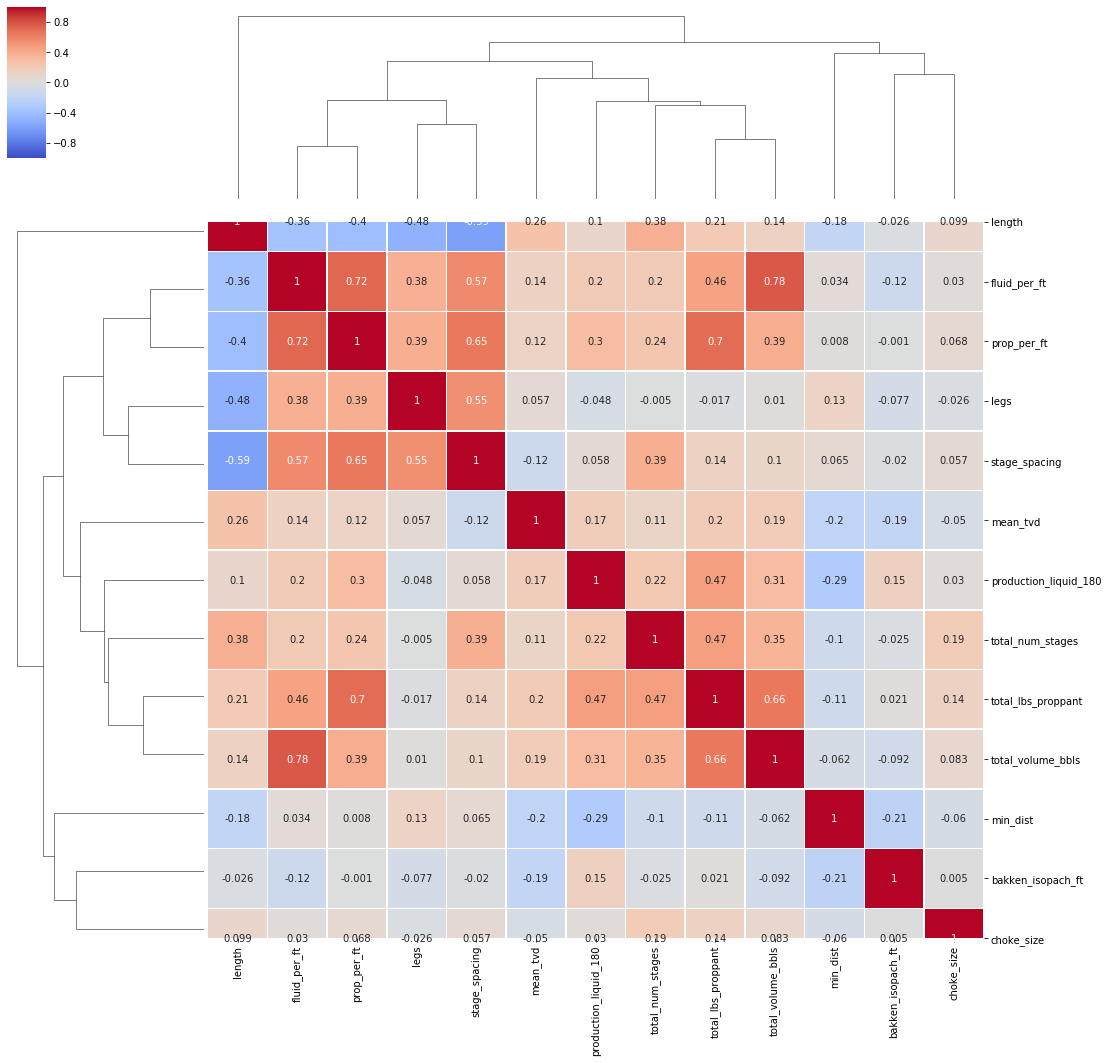

In [46]:
corr_df = clean_df.filter(foi).corr().round(3)

display(Markdown("### Correlation Matrix Heatmap, with Hierarchical Clustering"))
sns.clustermap(data=corr_df, 
                    cmap="coolwarm", 
                    linewidths=.5, 
                    vmin=-1, vmax=1, 
                    annot=True,
                   square=True
                )
fig = plt.gcf()  # or by other means, like plt.subplots
figsize = fig.get_size_inches()
fig.set_size_inches(figsize * 1.75)  # scale current size by 1.5

<a name="paragraph5"></a>
# Maps

In [47]:
map_df = (inspect_df.copy()
                      .filter(["surface_lng", "surface_lat", "mean_tvd", target_col, "stimulated_formation", "township", "countyname"])
                      .assign(township = lambda x: x["township"].dropna().apply(lambda x: int(x.split(" ")[0])))
                      .join(cat_df, lsuffix="_orig")
         )

### Where are highest producing wells?

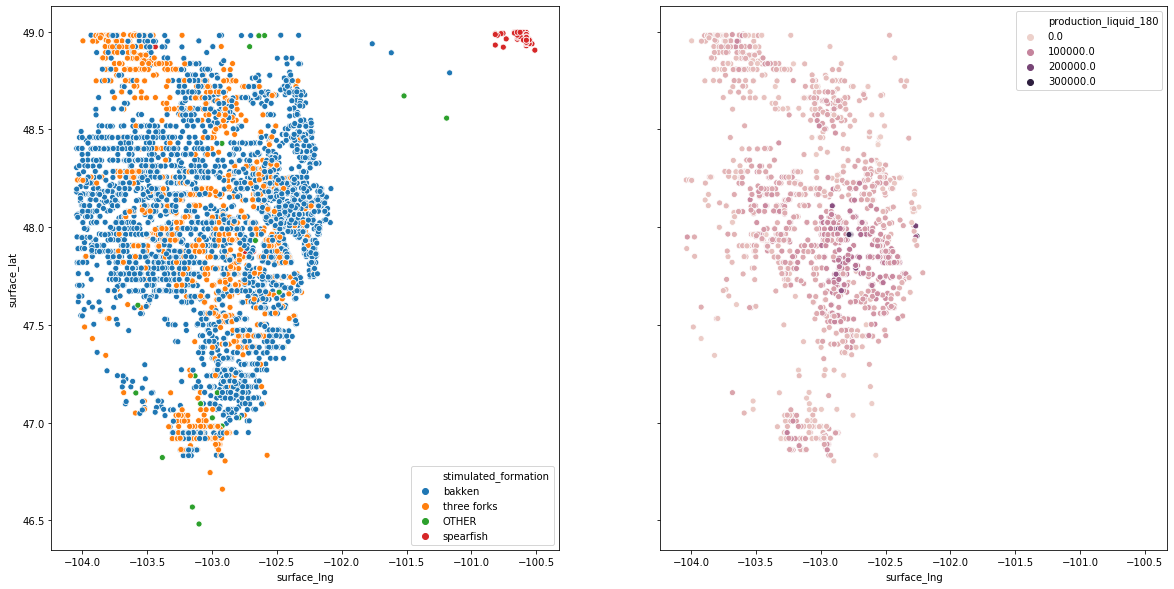

In [48]:
display(Markdown("### Where are highest producing wells?"))
fig, ax = plt.subplots(1, 2, figsize=(20,10), sharex=True, sharey=True)
sns.scatterplot(data=map_df, x="surface_lng", y="surface_lat", hue="stimulated_formation", ax=ax[0])
sns.scatterplot(data=map_df.query("stimulated_formation == 'three forks'"), x="surface_lng", y="surface_lat", hue=target_col, ax=ax[1])
plt.show()

### Political Geography: County and Township

township is basically just degrees latitude


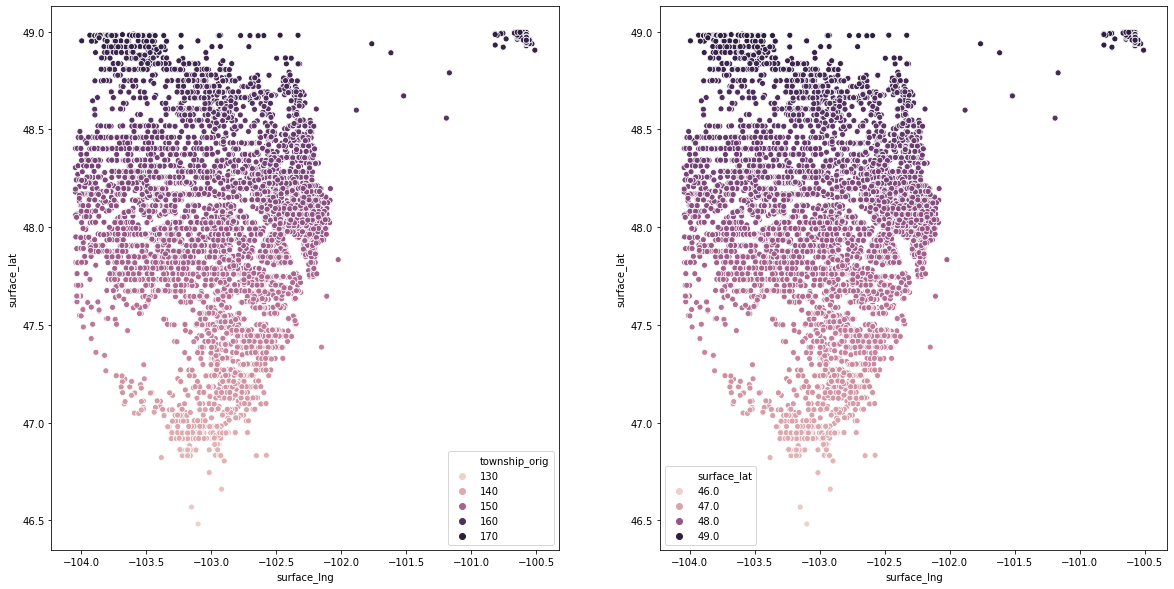

In [49]:
print("township is basically just degrees latitude")
fig, ax = plt.subplots(1, 2, figsize=(20,10))
sns.scatterplot(data=map_df, x="surface_lng", y="surface_lat", hue="township_orig", ax=ax[0])
sns.scatterplot(data=map_df, x="surface_lng", y="surface_lat", hue="surface_lat", ax=ax[1])

plt.show()

County is also just an administrative division, not a meaningful proxy for underlying geology.


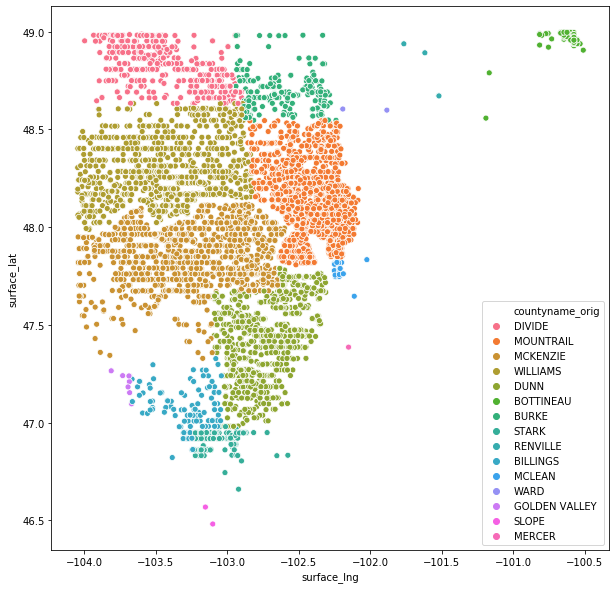

In [50]:
print("County is also just an administrative division, not a meaningful proxy for underlying geology.")
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=map_df, x="surface_lng", y="surface_lat", hue="countyname_orig")
plt.show()

### Target Formation and TVD

There is a group of wells in the NE corner are all much shallower. On the edge of the bowl.


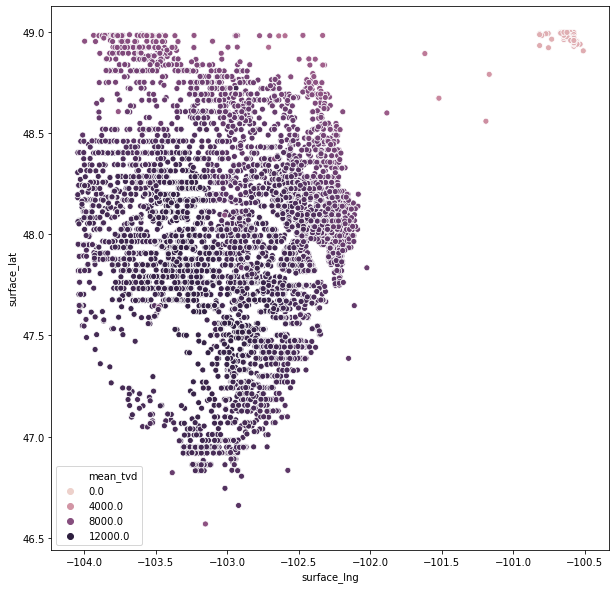

In [51]:
print("There is a group of wells in the NE corner are all much shallower. On the edge of the bowl.")
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=map_df, x="surface_lng", y="surface_lat", hue="mean_tvd")
plt.show()

Value Counts of Target Formation

bakken         4951
three forks    2016
NaN            1013
spearfish       104
OTHER            31
Name: stimulated_formation, dtype: int64

### Well Map, Colored and Faceted by Target Formation

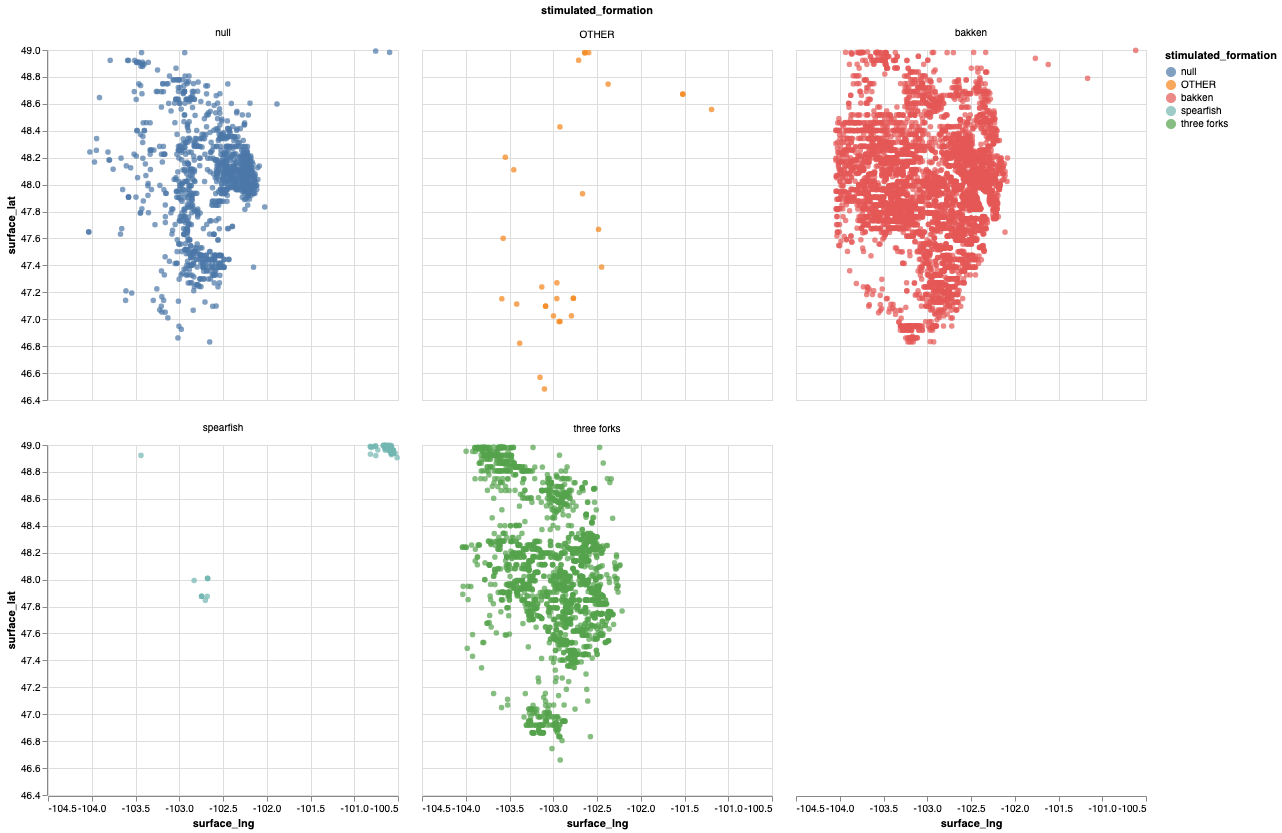

In [52]:
display(Markdown("Value Counts of Target Formation"),
        map_df.stimulated_formation.value_counts(dropna=False),
Markdown("### Well Map, Colored and Faceted by Target Formation"))
alt.Chart(map_df).mark_circle().encode(
    alt.X('surface_lng:Q',
        scale=alt.Scale(zero=False)
    ),
    alt.Y('surface_lat:Q',
        scale=alt.Scale(zero=False)
    ),
    color='stimulated_formation:N',
#     column='stimulated_formation:N'
).properties(
    width=350,
    height=350
).facet(
    facet='stimulated_formation:N',
    columns=3
)

In [53]:
print("All of those wells in the NE corner have no production data.")
inspect_df.query("surface_lng > -101.5").filter(regex="production").notnull().sum()

All of those wells in the NE corner have no production data.


production_liquid_120     0
production_liquid_150     0
production_liquid_180     0
production_liquid_1825    0
production_liquid_270     0
production_liquid_30      0
production_liquid_365     0
production_liquid_60      0
production_liquid_730     0
production_liquid_90      0
dtype: int64

In [54]:
print("Spearfish wells NOT in the NE corner DO HAVE production data.")
inspect_df.query("surface_lng < -101.5 & stimulated_formation == 'spearfish'").filter(regex="production").notnull().sum()

Spearfish wells NOT in the NE corner DO HAVE production data.


production_liquid_120     10
production_liquid_150     10
production_liquid_180     10
production_liquid_1825     0
production_liquid_270      6
production_liquid_30      10
production_liquid_365      5
production_liquid_60      10
production_liquid_730      1
production_liquid_90      10
dtype: int64

In [55]:
total_formation_vc = (inspect_df.copy()
                      .filter(["stimulated_formation"])
                      .squeeze()
                      .value_counts(dropna=False)
                      .sort_index()
                      .to_frame()
                      .reset_index()
                      .rename(columns={"index": "stimulated_formation", "stimulated_formation": "total_count"})
                     )

missing_target_formation_vc = (inspect_df.copy()
                               .query(f"{target_col} != {target_col}")
                               .filter(["stimulated_formation"])
                               .squeeze()
                               .value_counts(dropna=False)
                               .sort_index()
                              .reset_index()
                              .rename(columns={"index": "stimulated_formation", "stimulated_formation": "missing_target_count"})
                               )


explore_vc = total_formation_vc.merge(missing_target_formation_vc, on="stimulated_formation")



Spearfish wells account for a disproportionate number of missing values. Are they too young (recently drilled)?


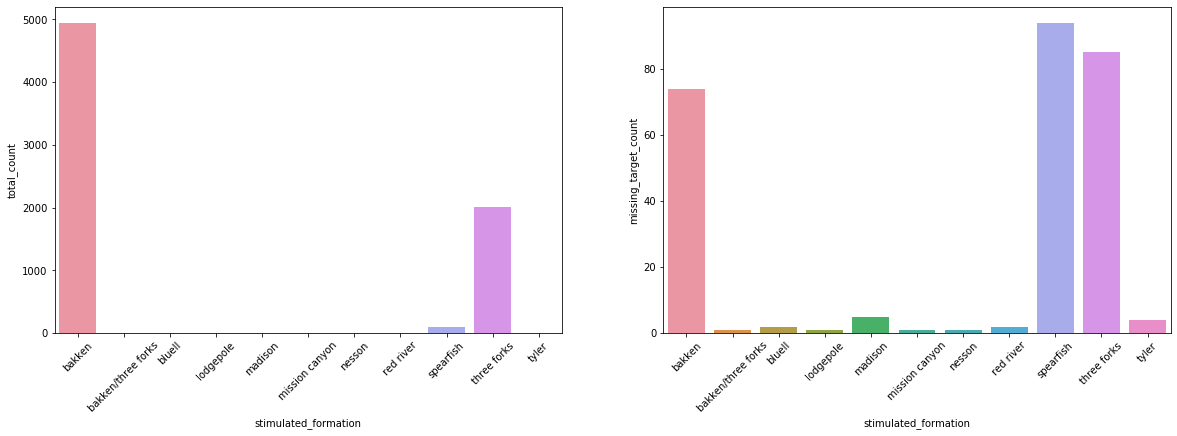

In [56]:
print("Spearfish wells account for a disproportionate number of missing values. Are they too young (recently drilled)?")
fig, ax  = plt.subplots(1,2, figsize=(20,6))
sns.barplot(data=explore_vc, x="stimulated_formation", y="total_count", ax=ax[0])
sns.barplot(data=explore_vc, x="stimulated_formation", y="missing_target_count", ax=ax[1])
for item in ax[0].get_xticklabels() + ax[1].get_xticklabels():
        item.set_rotation(45)

### 90% of Spearfish wells are missing, including all of those in the NE corner

In [57]:
spearfish_df = inspect_df.query("stimulated_formation == 'spearfish'")

### These are not just young wells. Still 90% missing at day 30.

In [58]:
display((spearfish_df.filter(regex="production_liquid").isnull().sum() / spearfish_df.shape[0] * 100).to_frame())

0
production_liquid_120   90.38
production_liquid_150   90.38
production_liquid_180   90.38
production_liquid_1825 100.00
production_liquid_270   94.23
production_liquid_30    90.38
production_liquid_365   95.19
production_liquid_60    90.38
production_liquid_730   99.04
production_liquid_90    90.38

### Visualize distance to nearest neighbor

In [59]:
inspect_df["min_dist"].describe()

count    7703.00
mean     2457.09
std      3414.10
min         0.51
25%       468.95
50%      1475.30
75%      3812.36
max     85421.41
Name: min_dist, dtype: float64

Seems like it worked


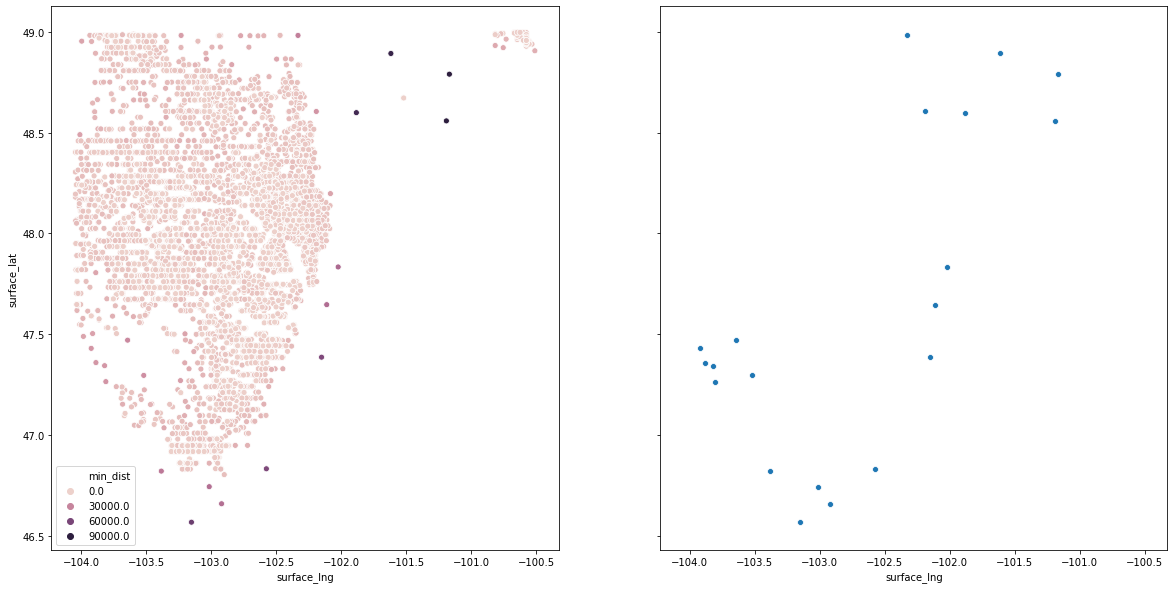

In [60]:
print("Seems like it worked")
fig, ax = plt.subplots(1, 2, figsize=(20,10), sharex=True, sharey=True)
sns.scatterplot(data=inspect_df, x="surface_lng", y="surface_lat", hue="min_dist", ax=ax[0])
sns.scatterplot(data=inspect_df.query("min_dist > 20000"), x="surface_lng", y="surface_lat", ax=ax[1])
plt.show()

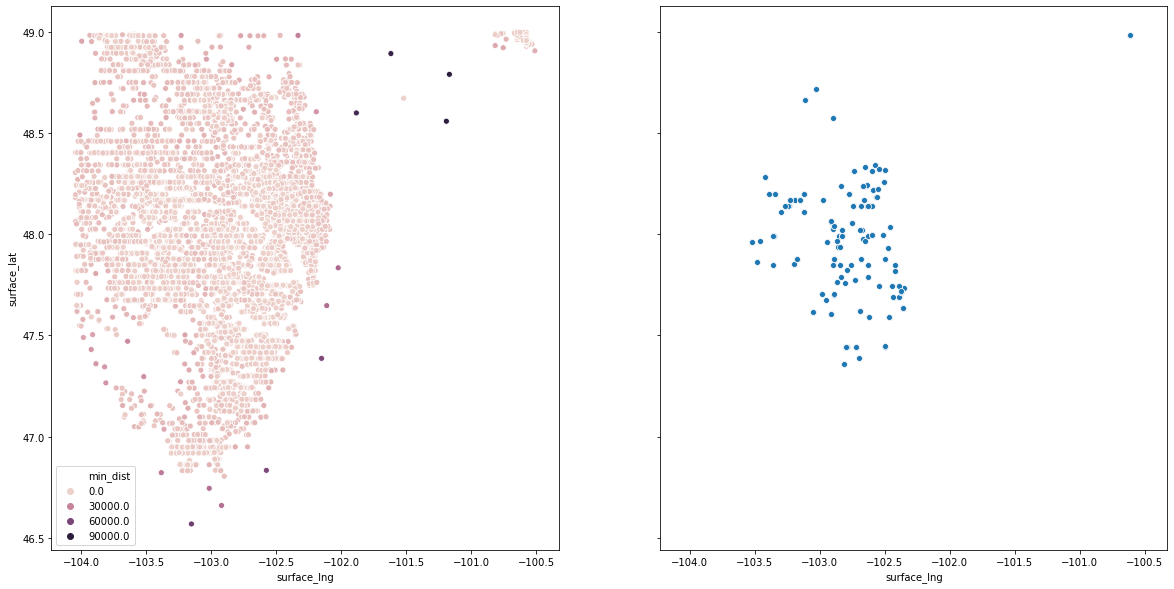

In [61]:
# The most densely spaced wells
fig, ax = plt.subplots(1, 2, figsize=(20,10), sharex=True, sharey=True)
sns.scatterplot(data=inspect_df, x="surface_lng", y="surface_lat", hue="min_dist", ax=ax[0])
sns.scatterplot(data=inspect_df.query("min_dist < 200"), x="surface_lng", y="surface_lat", ax=ax[1])
plt.show()

<a name="paragraph6"></a>
# Temporal Analysis

## Frac Year

In [62]:
date_df = (inspect_df.copy()
                      .assign(spud_year=lambda x: x["spud_date"].dropna().apply(lambda x: int(x.split("-")[0])))
          )

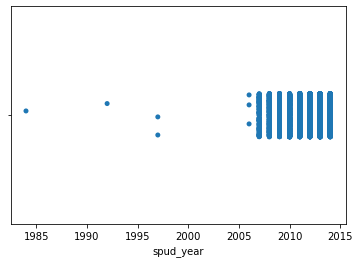

In [63]:
sns.stripplot(date_df.spud_year)

In [64]:
date_df.head()

bakken_isopach_ft  bh_lat  bh_lng  choke_size countyname  \
api                                                                        
33023010680000              90.00   48.73 -103.85        0.44     DIVIDE   
33061019000000             110.00   48.14 -102.33        1.00  MOUNTRAIL   
33053051430000              80.00   47.67 -102.87        0.28   MCKENZIE   
33053045070000              80.00   47.70 -102.71        0.34   MCKENZIE   
33053047660000              90.00   47.72 -103.25        0.61   MCKENZIE   

                                   currentoperator  \
api                                                  
33023010680000                    HUNT OIL COMPANY   
33061019000000     WHITING OIL AND GAS CORPORATION   
33053051430000         NEWFIELD PRODUCTION COMPANY   
33053045070000  ENERPLUS RESOURCES USA CORPORATION   
33053047660000     WHITING OIL AND GAS CORPORATION   

                                 currentwellname data_group  dfelev  \
api                                                                   
33023010680000    WRITING ROCK  161-101-30-31H-1       TEST     nan   
33061019000000                 JORGENSEN  11-27H       TEST     nan   
33053051430000  MOBERG FEDERAL  149-95-29-32-11H       TEST     nan   
33053045070000            CIRRUS  149-94-33D-28H       TEST     nan   
33053047660000               SMOKEY  3-17-20-14H       TEST     nan   

                   fieldname  ...  wellstatus welltype  mid_lat  mid_lng  \
api                           ...                                          
33023010680000  WRITING ROCK  ...           A       OG    48.74  -103.85   
33061019000000        SANISH  ...           A       OG    48.14  -102.35   
33053051430000      BEAR DEN  ...           A       OG    47.69  -102.87   
33053045070000    EAGLE NEST  ...           A       OG    47.69  -102.71   
33053047660000      PEMBROKE  ...           A       OG    47.73  -103.25   

               min_dist   length  prop_per_ft  fluid_per_ft  stage_spacing  \
api                                                                          
33023010680000  9667.07  6164.12       438.36          9.44           0.00   
33061019000000  1319.36  9150.57       204.01          2.97           0.00   
33053051430000   411.63  9926.80       166.36          1.62           0.00   
33053045070000  2760.67 10054.43       648.03          4.69           0.00   
33053047660000  3596.86  2785.10      1526.69         34.53           0.01   

                spud_year  
api                        
33023010680000    2013.00  
33061019000000    2011.00  
33053051430000    2013.00  
33053045070000    2012.00  
33053047660000    2013.00  

[5 rows x 61 columns]

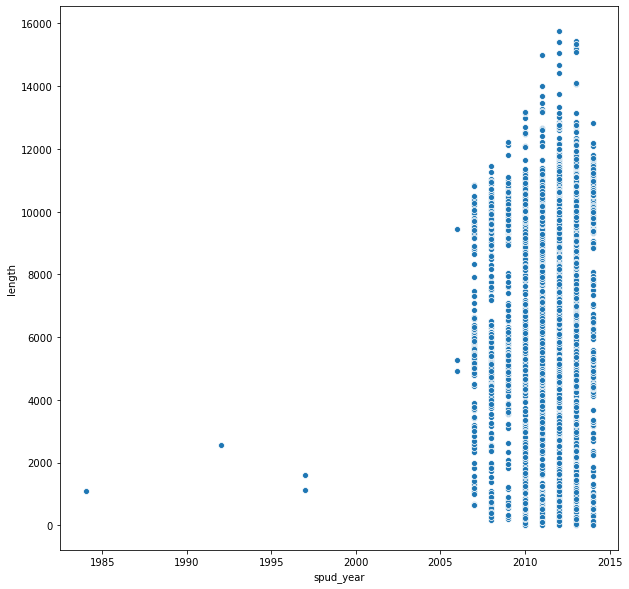

In [65]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=date_df, y="length", x="spud_year")

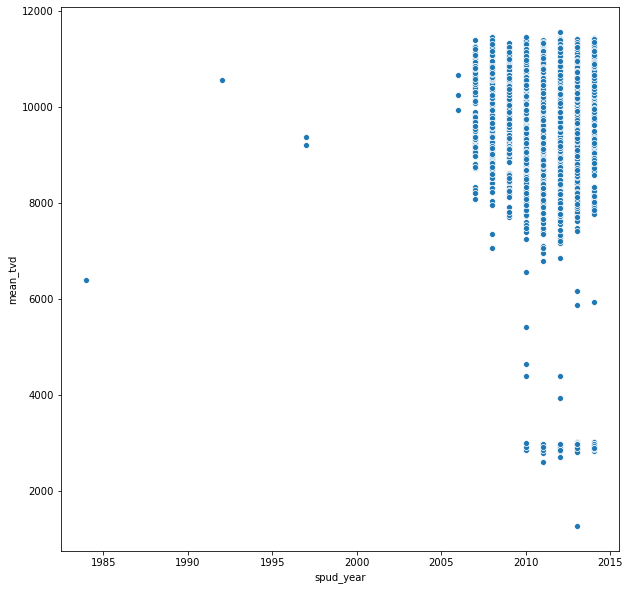

In [66]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=date_df, y="mean_tvd", x="spud_year")

In [67]:
date_df.query("spud_year < 2006")

bakken_isopach_ft  bh_lat  bh_lng  choke_size countyname  \
api                                                                        
33105014330000              70.00   48.20 -103.55         nan   WILLIAMS   
33053024160000              30.00   47.46 -103.64         nan   MCKENZIE   
33013011070000              70.00   48.74 -102.37         nan      BURKE   
33007013860000              20.00   46.82 -103.38         nan   BILLINGS   

                                       currentoperator       currentwellname  \
api                                                                            
33105014330000                            ZAVANNA, LLC        JEFFREY  33-33   
33053024160000                        EMERALD OIL, INC      FEDERAL  21-14HR   
33013011070000  PETRO HARVESTER OPERATING COMPANY, LLC          OPSETH  29-1   
33007013860000                    DENBURY ONSHORE, LLC  SOUTH FRYBURG  40-26   

               data_group  dfelev       fieldname  ...  wellstatus welltype  \
api                                                ...                        
33105014330000       TEST     nan       WILLISTON  ...          AB       OG   
33053024160000      TRAIN     nan  FLAT TOP BUTTE  ...           A       OG   
33013011070000      TRAIN     nan    SOUTH COTEAU  ...           A       OG   
33007013860000      TRAIN     nan         FRYBURG  ...           A       OG   

                mid_lat  mid_lng min_dist  length  prop_per_ft  fluid_per_ft  \
api                                                                            
33105014330000    48.20  -103.55  2068.30 1611.36          nan          0.01   
33053024160000    47.47  -103.64 27844.91 2563.09       403.54         11.26   
33013011070000    48.75  -102.37  3833.57 1085.17          nan          0.18   
33007013860000    46.82  -103.38 34964.89 1110.99        47.67          2.78   

                stage_spacing  spud_year  
api                                       
33105014330000           0.00    1997.00  
33053024160000           0.01    1992.00  
33013011070000           0.00    1984.00  
33007013860000           0.00    1997.00  

[4 rows x 61 columns]

In [68]:
date_df.query("wellbore in ['HORIZONTAL RE-ENTRY', 'DIRECTIONAL']").filter(["wellbore", "spud_date", "length", "stimulated_formation"]).sort_values("wellbore")

wellbore   spud_date  length stimulated_formation
api                                                                         
33061011940000          DIRECTIONAL  2010-02-04     nan          three forks
33007015830000          DIRECTIONAL  2010-04-10     nan              madison
33089005680000          DIRECTIONAL  2007-04-07     nan                  NaN
33025013510000          DIRECTIONAL  2011-05-28     nan            red river
33053043750000          DIRECTIONAL  2012-09-28     nan            red river
33053024160000  HORIZONTAL RE-ENTRY  1992-11-27 2563.09               bakken
33013011070000  HORIZONTAL RE-ENTRY  1984-10-30 1085.17               nesson
33023005530000  HORIZONTAL RE-ENTRY  2009-08-06 5734.45                  NaN
33101004750000  HORIZONTAL RE-ENTRY  2008-06-23 7603.19                  NaN
33007013860000  HORIZONTAL RE-ENTRY  1997-11-02 1110.99                tyler
33053027480000  HORIZONTAL RE-ENTRY  2008-01-31 2945.31                  NaN

In [69]:
date_df.query("wellbore == 'HORIZONTAL RE-ENTRY'").filter(["wellbore", "spud_date", "length", "stimulated_formation", target_col])

wellbore   spud_date  length stimulated_formation  \
api                                                                            
33053024160000  HORIZONTAL RE-ENTRY  1992-11-27 2563.09               bakken   
33013011070000  HORIZONTAL RE-ENTRY  1984-10-30 1085.17               nesson   
33023005530000  HORIZONTAL RE-ENTRY  2009-08-06 5734.45                  NaN   
33101004750000  HORIZONTAL RE-ENTRY  2008-06-23 7603.19                  NaN   
33007013860000  HORIZONTAL RE-ENTRY  1997-11-02 1110.99                tyler   
33053027480000  HORIZONTAL RE-ENTRY  2008-01-31 2945.31                  NaN   

                production_liquid_180  
api                                    
33053024160000               40223.00  
33013011070000                    nan  
33023005530000               18946.00  
33101004750000                    nan  
33007013860000                    nan  
33053027480000               21060.00

In [70]:
date_df.wellbore.value_counts()

HORIZONTAL             8104
HORIZONTAL RE-ENTRY       6
DIRECTIONAL               5
Name: wellbore, dtype: int64

## Production Data over time, for each well

In [71]:
inspect_df.query("production_liquid_90 > 0").shape

(7954, 61)

In [72]:
prod_df = (inspect_df.copy()
                   .filter(regex="production_liquid")
                   .query("production_liquid_30 > 0")
                   .rename(columns=lambda x: int(x.split("_")[-1]))
                   .drop([1825], axis=1)
                   .reset_index()
                   .melt(id_vars="api", value_name="cum_prod", var_name="ip_day")
                   .sort_values(["api", "ip_day"])
                   .reset_index(drop=True)
                   .assign(
                           ip_day=lambda x: x["ip_day"].astype(int),
                           cum_prod=lambda x: x["cum_prod"].astype(float),
                           day_diff=lambda x: x.groupby(["api"])["ip_day"].transform(pd.Series.diff),
                           prod_diff=lambda x: x.groupby(["api"])["cum_prod"].transform(pd.Series.diff),
                           prod_rate = lambda x: (x["prod_diff"] / x["day_diff"]).round(2)
                          )     
          )

In [73]:
prod_df.head()

api  ip_day  cum_prod  day_diff  prod_diff  prod_rate
0  33007015740000      30   4829.00       nan        nan        nan
1  33007015740000      60   9223.00     30.00    4394.00     146.47
2  33007015740000      90  12745.00     30.00    3522.00     117.40
3  33007015740000     120  15051.00     30.00    2306.00      76.87
4  33007015740000     150  15975.00     30.00     924.00      30.80

In [74]:
well_ids = inspect_df.index.to_list()
well_ids[:10]

['33023010680000',
 '33061019000000',
 '33053051430000',
 '33053045070000',
 '33053047660000',
 '33053049720000',
 '33061020550000',
 '33061025000000',
 '33053049810000',
 '33105023020000']

In [75]:
ip_days = sorted(prod_df.ip_day.unique())

In [76]:
ip_days

[30, 60, 90, 120, 150, 180, 270, 365, 730]

In [77]:
def plot_well_curve(prod_df, well_id):
    sub_df = prod_df.query("api == @well_id")
    display(Markdown(f"## {well_id}"))
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    ax[0].plot(sub_df["ip_day"], sub_df["cum_prod"], marker="o")
    ax[1].plot(sub_df["ip_day"], sub_df["prod_rate"],marker="o")
    plt.show()
    display(sub_df)

### Here is a normal-looking production curve

## 33053045070000

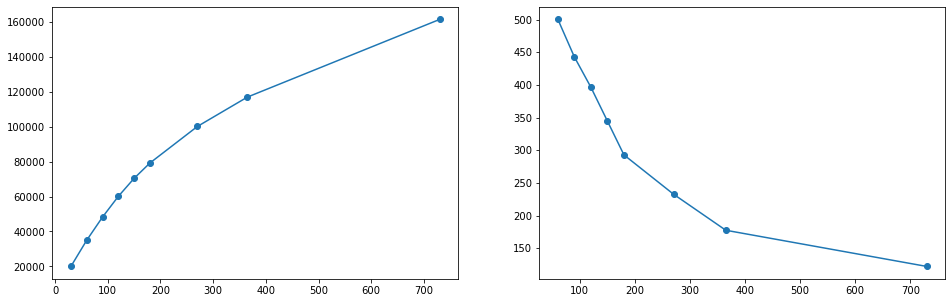

api  ip_day  cum_prod  day_diff  prod_diff  prod_rate
31329  33053045070000      30  19949.00       nan        nan        nan
31330  33053045070000      60  34958.00     30.00   15009.00     500.30
31331  33053045070000      90  48239.00     30.00   13281.00     442.70
31332  33053045070000     120  60128.00     30.00   11889.00     396.30
31333  33053045070000     150  70463.00     30.00   10335.00     344.50
31334  33053045070000     180  79246.00     30.00    8783.00     292.77
31335  33053045070000     270 100184.00     90.00   20938.00     232.64
31336  33053045070000     365 117038.00     95.00   16854.00     177.41
31337  33053045070000     730 161572.00    365.00   44534.00     122.01

In [78]:
well_oi = well_ids[3]
plot_well_curve(prod_df, well_oi)

### Here is an abnormal-looking production curve:
This is something that could be cleaned up to improve model accuracy.

## 33053044080000

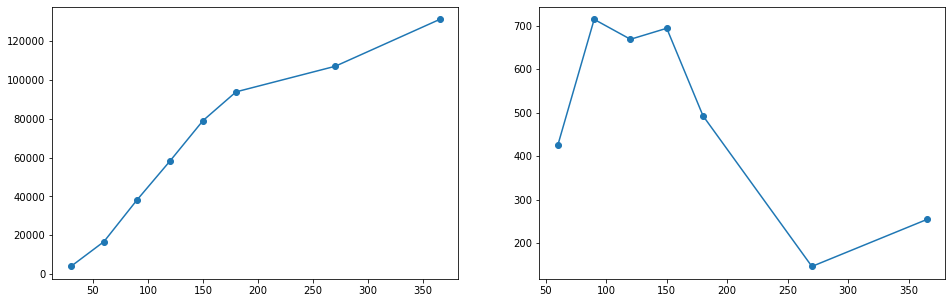

api  ip_day  cum_prod  day_diff  prod_diff  prod_rate
30726  33053044080000      30   3960.00       nan        nan        nan
30727  33053044080000      60  16727.00     30.00   12767.00     425.57
30728  33053044080000      90  38160.00     30.00   21433.00     714.43
30729  33053044080000     120  58218.00     30.00   20058.00     668.60
30730  33053044080000     150  79035.00     30.00   20817.00     693.90
30731  33053044080000     180  93811.00     30.00   14776.00     492.53
30732  33053044080000     270 106970.00     90.00   13159.00     146.21
30733  33053044080000     365 131117.00     95.00   24147.00     254.18
30734  33053044080000     730       nan    365.00        nan        nan

In [79]:
well_oi = well_ids[1001]
plot_well_curve(prod_df, well_oi)

<a name="paragraph7"></a>
# Preliminary model fitting

In [80]:
target_col = "production_liquid_180"

In [81]:
model_features = data_dict.query("using == True").index.tolist()
# model_features += coord_cols

In [82]:
model_features

['bakken_isopach_ft',
 'choke_size',
 'fluid_per_ft',
 'length',
 'min_dist',
 'production_liquid_180',
 'prop_per_ft',
 'spud_year',
 'stage_spacing',
 'std_tvd',
 'stimulated_formation',
 'surface_lat',
 'surface_lng',
 'total_lbs_proppant',
 'total_num_stages',
 'total_volume_bbls',
 'tvd']

In [83]:
inspect_df.spud_year.dtype

dtype('float64')

In [84]:
full_df = (inspect_df.copy()
               .dropna(subset=[target_col])
               .pipe(mwd.normalize_formation, "stimulated_formation", "producedpools")
               .filter(model_features)
          )

In [85]:
test_df, train_df = train_test_split(full_df)
train_X, train_y = mft.X_y_split(train_df, target=target_col)
test_X, test_y = mft.X_y_split(test_df, target=target_col)

In [86]:
gbr = GradientBoostingRegressor(learning_rate=0.01,
                                n_estimators=500, 
                                subsample = .7, 
                                max_depth =7, 
                                min_samples_split= 3, 
                                random_state=1984)

In [87]:
model = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy="median"),
        gbr
    )

In [88]:
model.fit(train_X, train_y)

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse',
                                           init=None, learning_rate=0.01,
                                           loss='ls', max_depth=7,
                                           max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=3,
                                           min_weight_fraction_leaf=0.0,
                   

### Error metrics

In [89]:
mse, mae, rmse, rrse = mft.eval_model(model, test_X, test_y, train_y)

y_hat = model.predict(test_X)

eval_df = (pd.concat([test_y.reset_index(), pd.Series(y_hat, name="pred").round(2)], axis=1)
           .set_index("api")
           .rename(columns={target_col: "actual"})
           .assign(resid=lambda x: x["pred"] - x["actual"])
           .assign(perc_resid=lambda x: x["resid"] / x["actual"] * 100)
           .assign(abs_resid=lambda x: x["resid"].abs())
           .assign(abs_perc_resid=lambda x: x["abs_resid"] / x["actual"] * 100)
          )

mape = eval_df.abs_perc_resid.mean()

mape_adj = eval_df.abs_resid.mean() / eval_df.actual.mean() * 100

In [90]:
error_dict = {"mae ": mae, "rmse": rmse, "rrse": rrse, "mape": mape, "adj_mape": mape_adj}

In [91]:
for name, val in error_dict.items():
    print(name, val.round())

mae  15729.0
rmse 21779.0
rrse 65.0
mape 39.0
adj_mape 26.0


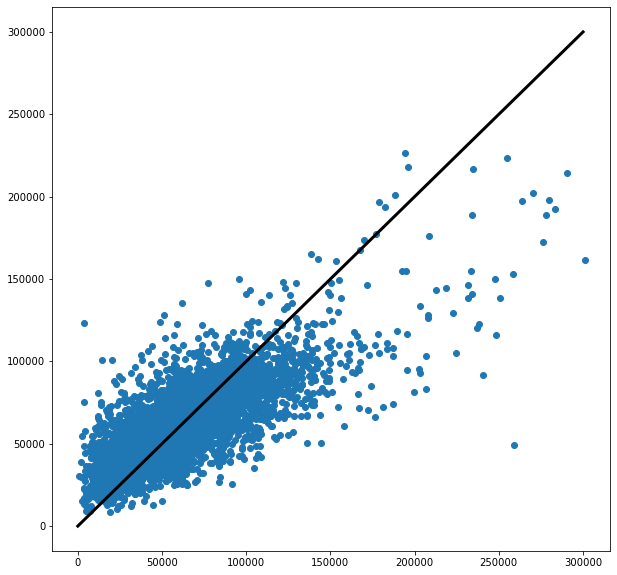

In [92]:
plt.subplots(figsize=(10, 10))
plt.scatter(data=eval_df, x="actual", y="pred")
plt.plot([0, 300000], [0, 300000], c="k", linewidth=3)

### The model is clearly biased: it's overpredicting small values and underpredicting large values

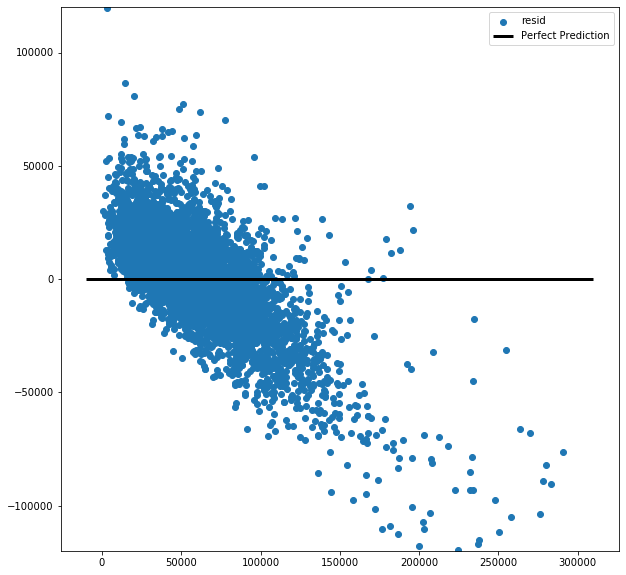

In [93]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(data=eval_df, x="actual", y="resid")
ax.set_ylim(-120000, 120000)
ax.hlines(y=0, xmin=-10000, xmax=310000, label="Perfect Prediction", linewidth=3)
plt.legend()

In [94]:
feat_imp_df = mft.get_rig_df(model['gradientboostingregressor'], train_X.columns.values)

In [95]:
feat_imp_df

importance
feature                         
total_lbs_proppant          0.20
surface_lat                 0.18
surface_lng                 0.11
bakken_isopach_ft           0.08
min_dist                    0.06
total_num_stages            0.06
tvd                         0.05
total_volume_bbls           0.05
stage_spacing               0.05
length                      0.04
std_tvd                     0.03
fluid_per_ft                0.02
prop_per_ft                 0.02
choke_size                  0.02
spud_year                   0.02
stimulated_formation        0.01

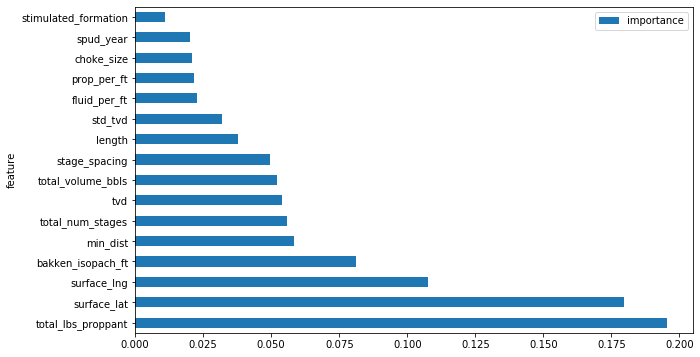

In [96]:
# This all makes sense
feat_imp_df.plot.barh(figsize=(10, 6), )

# Create instructions json
Based on our findings from data exploration, we are going to create some instructions for constructing a model-ready dataset.

In [127]:
blacklist_cols = data_dict.query("using == False").index.tolist()

for col in blacklist_cols:
    print(col)

api
bh_lat
bh_lng
countyname
currentoperator
currentwellname
data_group
dfelev
fieldname
fileno
footages
grelev
kbelev
leasename
leasenumber
legs
max_tvd
mean_tvd
min_tvd
num_pools_produced
originaloperator
originalwellname
producedpools
production_liquid_120
production_liquid_150
production_liquid_1825
production_liquid_270
production_liquid_30
production_liquid_365
production_liquid_60
production_liquid_730
production_liquid_90
qq
range
section
spud_date
td
township
type_treatment
well_status_date
wellbore
wellstatus
welltype


In [128]:
blacklist_cols.remove("api")
blacklist_cols.remove("data_group")

index_col = "api"

In [129]:
instructions = {
                "index_col": index_col,
                "coord_cols": coord_cols,
                "target_col": target_col,
                "blacklist_cols": blacklist_cols,
                "thresh_dict": dict(thresh_dict)
               }

In [130]:
instructions

{'index_col': 'api',
 'coord_cols': ['surface_lat', 'surface_lng', 'bh_lat', 'bh_lng'],
 'target_col': 'production_liquid_180',
 'blacklist_cols': ['bh_lat',
  'bh_lng',
  'countyname',
  'currentoperator',
  'currentwellname',
  'dfelev',
  'fieldname',
  'fileno',
  'footages',
  'grelev',
  'kbelev',
  'leasename',
  'leasenumber',
  'legs',
  'max_tvd',
  'mean_tvd',
  'min_tvd',
  'num_pools_produced',
  'originaloperator',
  'originalwellname',
  'producedpools',
  'production_liquid_120',
  'production_liquid_150',
  'production_liquid_1825',
  'production_liquid_270',
  'production_liquid_30',
  'production_liquid_365',
  'production_liquid_60',
  'production_liquid_730',
  'production_liquid_90',
  'qq',
  'range',
  'section',
  'spud_date',
  'td',
  'township',
  'type_treatment',
  'well_status_date',
  'wellbore',
  'wellstatus',
  'welltype'],
 'thresh_dict': {'total_lbs_proppant': {'min': 0, 'max': 20000000.0},
  'total_volume_bbls': {'min': 0, 'max': 500000.0},
  'leng

In [131]:
with open('../scripts/instructions.json', 'w') as fp:
    json.dump(instructions, fp)

In [132]:
with open('../scripts/instructions.json') as fp:
    instructions_test = json.load(fp)

In [133]:
instructions_test.keys()

dict_keys(['index_col', 'coord_cols', 'target_col', 'blacklist_cols', 'thresh_dict'])

In [134]:
instructions_test["thresh_dict"]

{'total_lbs_proppant': {'min': 0, 'max': 20000000.0},
 'total_volume_bbls': {'min': 0, 'max': 500000.0},
 'length': {'min': 2000, 'max': inf},
 'total_num_stages': {'min': 5, 'max': inf},
 'mean_tvd': {'min': 0, 'max': inf}}

### TODO:
- [X] Table of Contents,
- [ ] Add tvd cols to corr heatmap
- [ ] Flesh out narrative
- [ ] Import formation tops, recaluclate target formation
- [ ] Detect anomalies and impute production for young wells
- [ ] Regress against parameters of decline curves
